In [1]:
import os
import gc
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
import warnings

warnings.filterwarnings('ignore')

# Configuration
pd.set_option('display.max_columns', None)
TRAIN_WEEKS = range(1, 15)
VALID_WEEKS = range(15, 19)
LOOKBACK = 1

print("Environment Ready. Mode: M3 Max")

Environment Ready. Mode: M3 Max


In [2]:
def standardize_coordinates(df):
    df = df.copy()

    # 1. Standardize Directions (Left to Right)
    if 'play_direction' in df.columns:
        left_mask = df['play_direction'] == 'left'
        for col in ['x', 'y', 'ball_land_x', 'ball_land_y']:
            if col in df.columns:
                df.loc[left_mask, col] = (120 if 'x' in col else 53.3) - df.loc[left_mask, col]
        for col in ['dir', 'o']:
            if col in df.columns:
                df.loc[left_mask, col] = (df.loc[left_mask, col] + 180) % 360

    # 2. Convert to Radians
    if 'dir' in df.columns:
        df['dir_rad'] = np.radians(90 - df['dir'])
    if 'o' in df.columns:
        df['o_rad'] = np.radians(90 - df['o'])

    # Fix low speed orientation noise
    if 's' in df.columns and 'o_rad' in df.columns:
        low_speed_mask = df['s'] < 0.2
        df.loc[low_speed_mask, 'dir_rad'] = df.loc[low_speed_mask, 'o_rad']

    return df

In [3]:
def calculate_pairwise(df, lookback=LOOKBACK):
    """ Vectorized Nearest Opponent & Density """
    print(f"Calculating Pairwise Features (Vectorized)...")
    df = df.copy()

    # Identify relevant frames
    df_sorted = df.sort_values(['game_id', 'play_id', 'frame_id'])
    max_frames = df_sorted.groupby(['game_id', 'play_id'])['frame_id'].max().reset_index()
    max_frames.columns = ['game_id', 'play_id', 'max_frame']

    df_context = df_sorted.merge(max_frames, on=['game_id', 'play_id'])

    # Helper to process slices (Current vs Past)
    def process_slice(offset, suffix):
        slice_df = df_context[df_context['frame_id'] == (df_context['max_frame'] - offset)].copy()
        if slice_df.empty: return pd.DataFrame()

        # Cartesian join for players in same play
        cols = ['game_id', 'play_id', 'nfl_id', 'x', 'y']
        if 'player_role' in slice_df.columns: cols.append('player_role')

        merged = slice_df[cols].merge(slice_df[cols], on=['game_id', 'play_id'], suffixes=('', '_opp'))

        # Filter: Only Opponents
        merged = merged[merged['nfl_id'] != merged['nfl_id_opp']]

        # Distance calc
        merged['dist'] = np.sqrt((merged['x_opp'] - merged['x'])**2 + (merged['y_opp'] - merged['y'])**2)

        # 1. Nearest Opponent
        nearest = merged.sort_values(['game_id', 'play_id', 'nfl_id', 'dist']) \
                        .groupby(['game_id', 'play_id', 'nfl_id']).first().reset_index()

        # 2. Density
        merged['density_score'] = 1 / (merged['dist']**2 + 1)
        density = merged.groupby(['game_id', 'play_id', 'nfl_id'])['density_score'].sum().reset_index()

        # Format Result (Calculate dx/dy here to be safe from KeyErrors)
        res = nearest[['game_id', 'play_id', 'nfl_id', 'dist']].copy()

        # Recalculate dx/dy from the nearest row to ensure correctness
        res[f'opp_dx_{suffix}'] = nearest['x_opp'] - nearest['x']
        res[f'opp_dy_{suffix}'] = nearest['y_opp'] - nearest['y']
        res[f'opp_dist_{suffix}'] = res['dist']

        # Drop the raw 'dist' column to avoid confusion
        res = res.drop(columns=['dist'])

        res = res.merge(density, on=['game_id', 'play_id', 'nfl_id'], how='left')
        res.rename(columns={'density_score': f'density_{suffix}'}, inplace=True)

        return res

    feat_curr = process_slice(0, 'curr')
    feat_past = process_slice(lookback, 'past')

    if not feat_curr.empty: df = df.merge(feat_curr, on=['game_id', 'play_id', 'nfl_id'], how='left')
    if not feat_past.empty: df = df.merge(feat_past, on=['game_id', 'play_id', 'nfl_id'], how='left')

    cols_to_fill = [c for c in df.columns if 'opp_' in c or 'density_' in c]
    df[cols_to_fill] = df[cols_to_fill].fillna(0)
    return df

In [4]:
def engineer_features(df):
    df = df.copy()

    # A. Time & Space
    df['time_delta'] = (df['frame_id'] - 1) * 0.1
    df['total_time'] = df['num_frames_output'] * 0.1

    # ==========================================================================
    # B. OPTIMIZED PHYSICS BASELINE (Findings: Base=0.6, Slope=-0.06, Brake=-1.0)
    # ==========================================================================

    # 1. Base Inertia (Slippery: 0.6 is much lower than original 0.8)
    alpha_base = 0.60 + (df['start_s'] * -0.06)

    # 2. Tangential Acceleration Logic
    # We use .get() to be safe if s_past is missing
    s_past = df.get('start_s_past', df['start_s'])
    tangential_accel = (df['start_s'] - s_past) / (LOOKBACK * 0.1)

    # *** for the ML Model to know if running or braking ***
    df['accel_actual'] = tangential_accel

    # 3. Dynamic Braking Penalty
    # Weight = -1.0 (Grid Search)
    braking_penalty = np.clip(tangential_accel * -1.0, 0.0, 5.0)

    # 4. Final Alpha
    alpha = np.clip(alpha_base + braking_penalty, 0.1, 5.0)

    # 5. Damping
    t = df['time_delta']
    damp_factor = (1 - np.exp(-alpha * t)) / alpha
    # ==========================================================================

    # Global Velocity
    df['v0_x'] = df['start_s'] * np.cos(df['start_dir_rad'])
    df['v0_y'] = df['start_s'] * np.sin(df['start_dir_rad'])

    # Baseline Pos
    base_x_global = df['start_x'] + (df['v0_x'] * damp_factor)
    base_y_global = df['start_y'] + (df['v0_y'] * damp_factor)

    # Clamp
    base_y_clamped = np.clip(base_y_global, 0.5, 52.8)
    base_x_clamped = np.clip(base_x_global, 0.5, 119.5)

    df['base_dx'] = base_x_clamped - df['start_x']
    df['base_dy'] = base_y_clamped - df['start_y']

    # C. Ego-Centric Rotation Setup
    theta = df['start_dir_rad']
    c, s = np.cos(theta), np.sin(theta)

    # --- ROTATE VELOCITY ---
    df['v_fwd'] = (df['v0_x'] * c) + (df['v0_y'] * s)
    df['v_lat'] = -(df['v0_x'] * s) + (df['v0_y'] * c)

    # E. OPPONENT VECTORS
    df['opp_dx'] = df['opp_dx_curr']
    df['opp_dy'] = df['opp_dy_curr']
    df['opp_fwd'] = (df['opp_dx'] * c) + (df['opp_dy'] * s)
    df['opp_lat'] = -(df['opp_dx'] * s) + (df['opp_dy'] * c)

    # F. BIOMECHANICS
    diff_deg = (df['start_dir_deg'] - df['start_dir_deg_past'])
    diff_deg = (diff_deg + 180) % 360 - 180
    df['angular_velocity'] = diff_deg / (LOOKBACK * 0.1)

    df['angle_diff'] = np.abs(df['start_dir_rad'] - df['start_o_rad'])
    df['angle_diff'] = np.where(df['angle_diff'] > np.pi, (2*np.pi) - df['angle_diff'], df['angle_diff'])
    df['centripetal_force'] = np.clip((df['start_s']**2) * np.abs(np.radians(df['angular_velocity'])), 0, 15)

    # G. BALL TARGET
    if 'target_dx' in df.columns:
        global_res_dx = df['target_dx'] - df['base_dx']
        global_res_dy = df['target_dy'] - df['base_dy']
        df['res_fwd'] = (global_res_dx * c) + (global_res_dy * s)
        df['res_lat'] = -(global_res_dx * s) + (global_res_dy * c)

    # H. GAME THEORY: BALL ARRIVAL
    vec_to_land_x = df['ball_land_x'] - df['start_x']
    vec_to_land_y = df['ball_land_y'] - df['start_y']
    df['dist_to_ball'] = np.hypot(vec_to_land_x, vec_to_land_y)

    # Vector to Ball in Ego-Frame
    df['ball_land_fwd'] = (vec_to_land_x * c) + (vec_to_land_y * s)
    df['ball_land_lat'] = -(vec_to_land_x * s) + (vec_to_land_y * c)

    # Are we looking at the ball?
    angle_to_ball = np.arctan2(vec_to_land_y, vec_to_land_x)
    df['look_at_ball_cos'] = np.cos(angle_to_ball - df['start_o_rad'])
    df['cos_angle_to_land'] = df['ball_land_fwd'] / (df['dist_to_ball'] + 1e-5)

    # I. GAME THEORY: PURSUIT GEOMETRY
    df['opp_dx_past'] = df['opp_dx_past'].fillna(df['opp_dx_curr'])
    df['opp_dy_past'] = df['opp_dy_past'].fillna(df['opp_dy_curr'])

    opp_vx_global = (df['opp_dx_curr'] - df['opp_dx_past']) / (LOOKBACK * 0.1)
    opp_vy_global = (df['opp_dy_curr'] - df['opp_dy_past']) / (LOOKBACK * 0.1)

    df['vector_alignment'] = (df['v0_x'] * opp_vx_global + df['v0_y'] * opp_vy_global)

    df['closing_speed'] = (df['opp_dist_curr'] - df['opp_dist_past']) / (0.1 * LOOKBACK)
    df['time_to_intercept'] = df['opp_dist_curr'] / (df['closing_speed'].abs().clip(lower=0.5))
    df['collision_urgency'] = df['opp_dist_curr'] / (df['closing_speed'].clip(lower=-0.01) - 1e-6)

    df['ball_closing_speed'] = (df['v0_x'] * vec_to_land_x + df['v0_y'] * vec_to_land_y) / (df['dist_to_ball'] + 0.1)
    df['ball_urgency'] = (df['ball_closing_speed'] * df['total_time']) / (df['dist_to_ball'] + 1e-5)

    # Boundaries
    df['dist_to_sideline'] = np.minimum(df['start_y'], 53.3 - df['start_y'])
    df['dist_to_endzone'] = 120 - df['start_x']

    df['sideline_danger'] = np.where(df['dist_to_sideline'] < 2.0, np.abs(df['v_lat']), 0)

    return df

In [5]:
# ==============================================================================
# OPTIMIZED FEATURE SETS (Findings from the recursive feature elimination procedure)
# ==============================================================================
# 23 Features
FEATS_FWD = [
    'time_delta', 'total_time', 'start_s', 'nfl_id', 'accel_actual',
    'start_a', 'angular_velocity', 'centripetal_force', 'angle_diff',
    'dist_to_ball', 'opp_dist_curr', 'opp_fwd', 'opp_lat', 'closing_speed',
    'ball_urgency', 'ball_land_fwd', 'ball_land_lat', 'look_at_ball_cos',
    'vector_alignment', 'density_curr', 'dist_to_endzone',
    'time_to_intercept', 'cos_angle_to_land'
]

# 26 Features
FEATS_LAT = [
    'time_delta', 'start_s', 'is_offense', 'nfl_id', 'accel_actual',
    'start_a', 'angular_velocity', 'centripetal_force', 'angle_diff',
    'dist_to_ball', 'opp_dist_curr', 'opp_fwd', 'opp_lat', 'closing_speed',
    'collision_urgency', 'ball_urgency', 'ball_land_fwd', 'ball_land_lat',
    'look_at_ball_cos', 'vector_alignment', 'density_curr',
    'dist_to_sideline', 'dist_to_endzone', 'time_to_intercept',
    'cos_angle_to_land',
    'total_time'
]

In [6]:
def load_and_process(weeks):
    data_dir = "../data/raw/train"
    if not os.path.exists(data_dir):
        data_dir = "/kaggle/input/nfl-big-data-bowl-2025/train"

    inputs, outputs = [], []
    print("Loading raw CSVs...")
    for w in weeks:
        week_str = f"w{str(w).zfill(2)}"
        in_path = f"{data_dir}/input_2023_{week_str}.csv"
        out_path = f"{data_dir}/output_2023_{week_str}.csv"

        if not os.path.exists(in_path): continue

        i = pd.read_csv(in_path)
        o = pd.read_csv(out_path)

        i = i.dropna(subset=['nfl_id']).copy()
        o = o.dropna(subset=['nfl_id']).copy()

        i['nfl_id'] = i['nfl_id'].astype(int)
        o['nfl_id'] = o['nfl_id'].astype(int)

        i['week'] = w
        inputs.append(i)
        outputs.append(o)

    if not inputs:
        print("No data found!")
        return pd.DataFrame()

    print("Merging & Standardizing...")
    input_df = pd.concat(inputs, ignore_index=True)
    output_df = pd.concat(outputs, ignore_index=True)

    input_df = standardize_coordinates(input_df)

    # 1. Calc Pairwise
    input_df = calculate_pairwise(input_df, lookback=LOOKBACK)

    # 2. History Extraction
    input_df = input_df.sort_values(['game_id','play_id','frame_id'])

    # Orientation History
    input_df['dir_past'] = input_df.groupby(['game_id','play_id','nfl_id'])['dir'].shift(LOOKBACK)
    input_df['dir_past'] = input_df['dir_past'].fillna(input_df['dir'])

    # Speed History (Important for Braking Detection)
    input_df['s_past'] = input_df.groupby(['game_id','play_id','nfl_id'])['s'].shift(LOOKBACK)
    input_df['s_past'] = input_df['s_past'].fillna(input_df['s'])

    # 3. Snapshot (Last Frame)
    snapshot = input_df.sort_values(['game_id', 'play_id', 'frame_id']) \
        .groupby(['game_id', 'play_id', 'nfl_id']).tail(1)

    rename_dict = {
        'x': 'start_x', 'y': 'start_y', 's': 'start_s', 'a': 'start_a',
        'dir_rad': 'start_dir_rad', 'o_rad': 'start_o_rad',
        'dir': 'start_dir_deg', 'o': 'start_o_deg',
        'dir_past': 'start_dir_deg_past',
        's_past': 'start_s_past' # New Column
    }
    snapshot = snapshot.rename(columns=rename_dict)
    if 'frame_id' in snapshot.columns: snapshot = snapshot.drop(columns=['frame_id'])

    # 4. Merge Targets
    targets = output_df[['game_id', 'play_id', 'nfl_id', 'frame_id', 'x', 'y']]
    merged = targets.merge(snapshot, on=['game_id', 'play_id', 'nfl_id'], how='inner')

    # Flip targets
    left_mask = merged['play_direction'] == 'left'
    merged.loc[left_mask, 'x'] = 120 - merged.loc[left_mask, 'x']
    merged.loc[left_mask, 'y'] = 53.3 - merged.loc[left_mask, 'y']

    merged['target_dx'] = merged['x'] - merged['start_x']
    merged['target_dy'] = merged['y'] - merged['start_y']

    # 5. Role Context
    if 'player_role' in merged.columns:
        merged['is_offense'] = merged['player_role'].isin(['Targeted Receiver', 'Ball Carrier']).astype(int)
    else:
        # Fallback
        if 'possessionTeam' in merged.columns and 'club' in merged.columns:
            merged['is_offense'] = (merged['club'] == merged['possessionTeam']).astype(int)
        elif 'possession_team' in merged.columns and 'club' in merged.columns:
             merged['is_offense'] = (merged['club'] == merged['possession_team']).astype(int)
        elif 'possessionTeam' in merged.columns and 'team' in merged.columns:
             merged['is_offense'] = (merged['team'] == merged['possessionTeam']).astype(int)
        else:
            merged['is_offense'] = 0

    print("Running Physics Engine...")
    final_df = engineer_features(merged)

    return final_df

full_df = load_and_process(list(TRAIN_WEEKS) + list(VALID_WEEKS))
gc.collect()
print(f"Dataset Ready. Rows: {len(full_df)}")

Loading raw CSVs...
Merging & Standardizing...
Calculating Pairwise Features (Vectorized)...
Running Physics Engine...
Dataset Ready. Rows: 562936


--- Running PCA for Offense ---
Original Feature Count: 25
Explained Variance by top 2 components: 30.97%
Explained Variance by top 3 components: 38.40%
--- Running PCA for Defense ---
Original Feature Count: 25
Explained Variance by top 2 components: 25.66%
Explained Variance by top 3 components: 33.06%


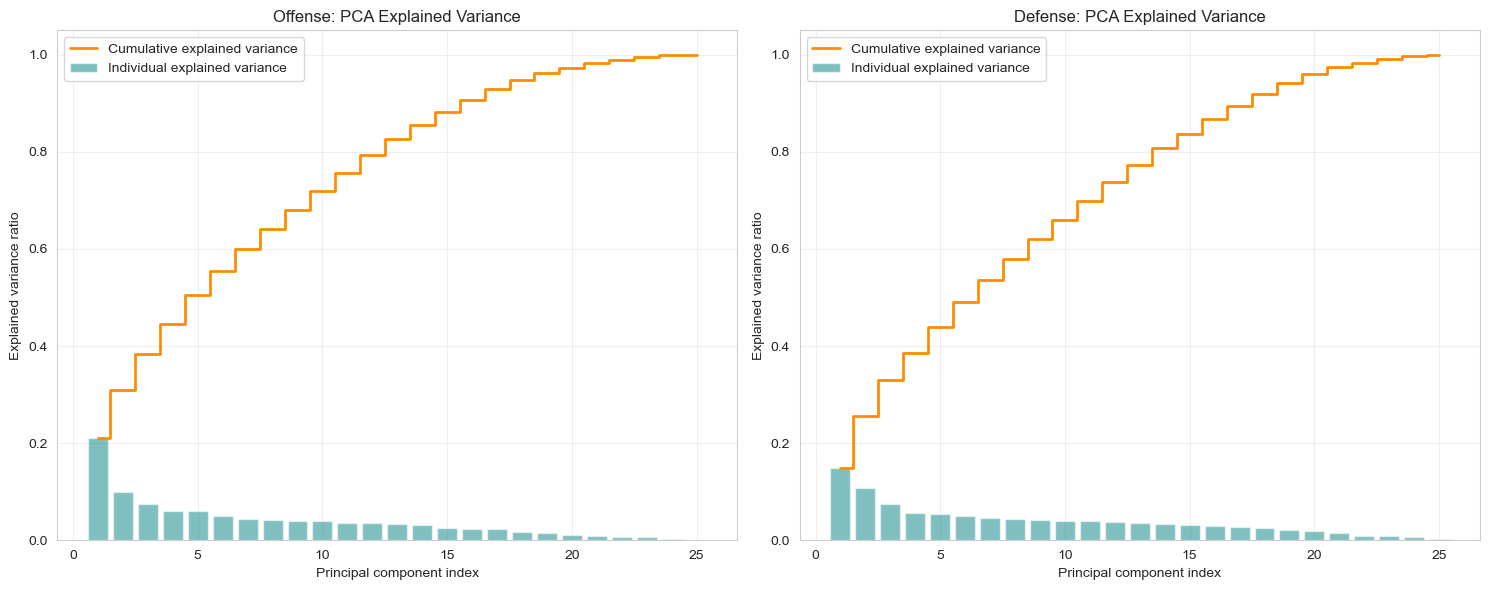


--- OFFENSE DRIVERS ---
Top features influencing PC1 (Primary Axis):
                        PC1
ball_land_fwd      0.391934
dist_to_ball       0.385207
start_s            0.343161
total_time         0.338053
angle_diff        -0.281563
cos_angle_to_land  0.249076
time_delta         0.231713
opp_dist_curr     -0.224839

Top features influencing PC2 (Secondary Axis):
                        PC2
opp_dist_curr      0.393146
start_a           -0.374444
cos_angle_to_land  0.351798
ball_urgency       0.332669
opp_fwd           -0.312890
density_curr      -0.292089
closing_speed      0.289184
accel_actual       0.214941

--- DEFENSE DRIVERS ---
Top features influencing PC1 (Primary Axis):
                        PC1
ball_land_fwd      0.446313
cos_angle_to_land  0.405308
dist_to_ball       0.370372
total_time         0.366919
ball_urgency       0.341498
time_delta         0.266803
start_s            0.241323
accel_actual       0.209011


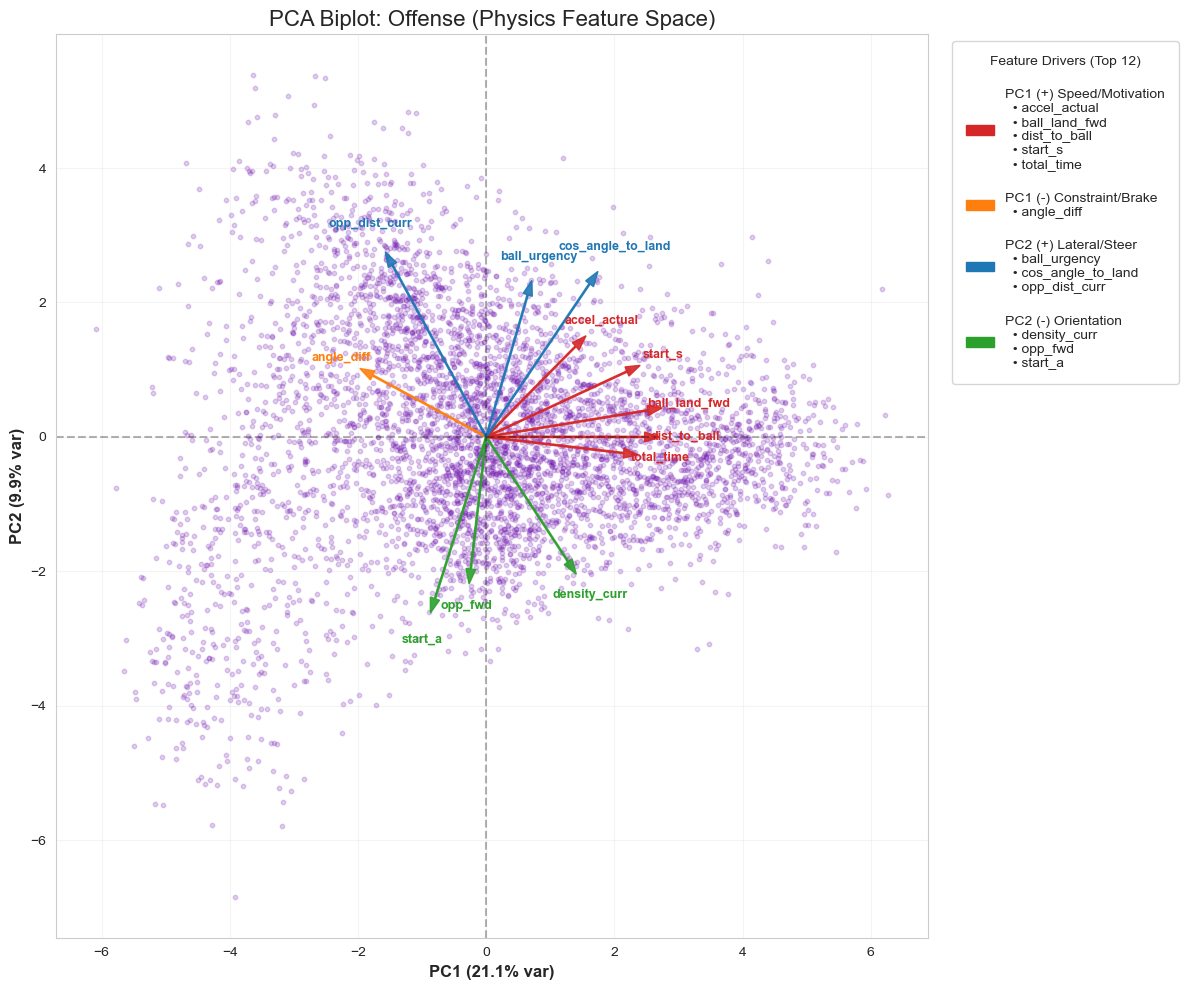

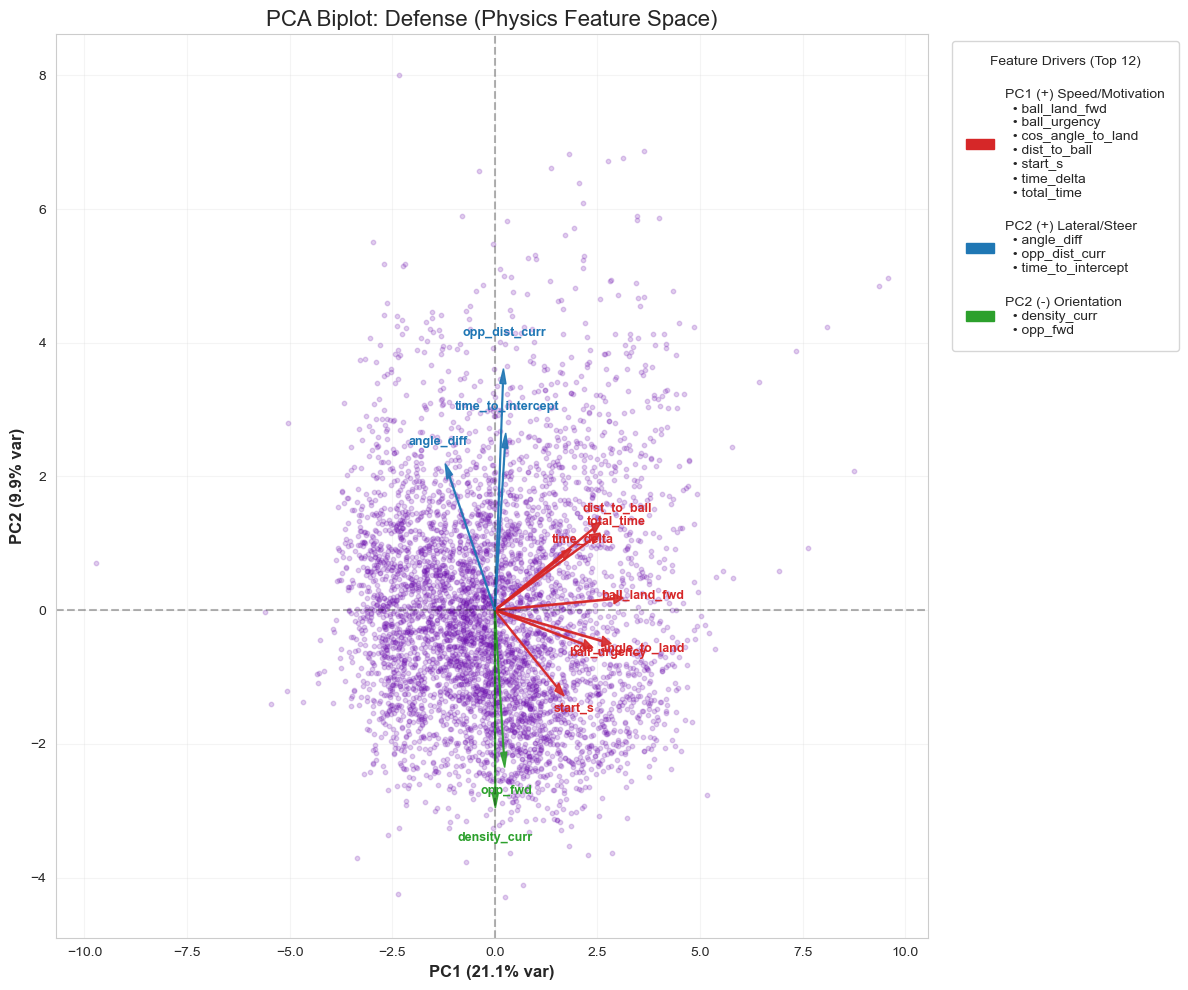

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns

# ==============================================================================
# 1. PREPARE FEATURES FOR PCA
# ==============================================================================
# This combines both Forward and Lateral feature sets
PCA_FEATURES = [
    # Kinematics
    'start_s', 'start_a', 'accel_actual', 'angular_velocity', 'centripetal_force',
    # Biomechanics
    'angle_diff',
    # Context / Game Theory
    'dist_to_ball', 'ball_urgency', 'look_at_ball_cos',
    'closing_speed', 'collision_urgency', 'time_to_intercept',
    'opp_dist_curr', 'opp_fwd', 'opp_lat', 'vector_alignment',
    'density_curr',
    # Geometry
    'ball_land_fwd', 'ball_land_lat', 'cos_angle_to_land',
    # Boundaries
    'dist_to_endzone', 'dist_to_sideline', 'sideline_danger',
    # Time
    'total_time', 'time_delta'
]


def get_pca_data(df, side_filter):
    """ Extracts clean feature matrix for Offense or Defense """
    # Filter by side (1=Offense, 0=Defense in our pipeline)
    is_offense = 1 if side_filter == 'Offense' else 0

    # Filter columns and rows
    # Just in case, we remove rows with NaNs to ensure PCA runs smoothly
    subset = df[df['is_offense'] == is_offense][PCA_FEATURES].dropna()

    return subset

# ==============================================================================
# 2. RUN PCA ENGINE
# ==============================================================================
def run_pca_analysis(df, side, n_components=None):
    print(f"--- Running PCA for {side} ---")
    X = get_pca_data(df, side)
    feature_names = X.columns.tolist()

    # Standardize (Mean=0, Std=1) for PCA
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Fit PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    # Variance Stats
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    print(f"Original Feature Count: {X.shape[1]}")
    print(f"Explained Variance by top 2 components: {cumulative_variance[1]:.2%}")
    print(f"Explained Variance by top 3 components: {cumulative_variance[2]:.2%}")

    return X_scaled, pca, X_pca, feature_names, explained_variance, cumulative_variance


# Execute for both sides
sample_df = full_df.sample(min(50000, len(full_df)), random_state=42)

X_off, pca_off, X_pca_off, feats_off, var_off, cum_var_off = run_pca_analysis(full_df, 'Offense')
X_def, pca_def, X_pca_def, feats_def, var_def, cum_var_def = run_pca_analysis(full_df, 'Defense')

# ==============================================================================
# 3. PLOT 1: EXPLAINED VARIANCE
# ==============================================================================
def plot_explained_variance(var_off, cum_var_off, var_def, cum_var_def):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Helper to plot one side
    def _plot(ax, var, cum, title):
        x_range = range(1, len(var) + 1)
        ax.bar(x_range, var, alpha=0.5, align='center', label='Individual explained variance', color='teal')
        ax.step(x_range, cum, where='mid', label='Cumulative explained variance', color='darkorange', linewidth=2)
        ax.set_ylabel('Explained variance ratio')
        ax.set_xlabel('Principal component index')
        ax.set_title(title)
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1.05)

    _plot(axes[0], var_off, cum_var_off, 'Offense: PCA Explained Variance')
    _plot(axes[1], var_def, cum_var_def, 'Defense: PCA Explained Variance')

    plt.tight_layout()
    plt.show()


plot_explained_variance(var_off, cum_var_off, var_def, cum_var_def)

# ==============================================================================
# 4. LOADINGS ANALYSIS (What do the components mean?)
# ==============================================================================
def analyze_loadings(pca_model, feature_names, component_index=0):
    loadings = pd.DataFrame(
        pca_model.components_.T,
        columns=[f'PC{i + 1}' for i in range(pca_model.n_components_)],
        index=feature_names
    )
    target_pc = f'PC{component_index + 1}'
    loadings['abs_loading'] = loadings[target_pc].abs()
    # Return sorted by impact
    return loadings.sort_values('abs_loading', ascending=False)[[target_pc]]


print("\n--- OFFENSE DRIVERS ---")
print("Top features influencing PC1 (Primary Axis):")
print(analyze_loadings(pca_off, feats_off, 0).head(8))
print("\nTop features influencing PC2 (Secondary Axis):")
print(analyze_loadings(pca_off, feats_off, 1).head(8))

print("\n--- DEFENSE DRIVERS ---")
print("Top features influencing PC1 (Primary Axis):")
print(analyze_loadings(pca_def, feats_def, 0).head(8))

# ==============================================================================
# 5. PLOT 2: PCA BIPLOT
# ==============================================================================
def plot_pca_biplot(X_scaled, pca_model, features, side):
    # Transform and take a random subset for cleaner plotting
    # We use indices to keep correspondence between X and score
    n_samples = min(5000, X_scaled.shape[0])
    indices = np.random.choice(X_scaled.shape[0], n_samples, replace=False)

    score = pca_model.transform(X_scaled[indices, :])
    coeff = pca_model.components_.T

    fig, ax = plt.subplots(figsize=(12, 10))

    # 1. Scatter Plot of Points (Plays)
    ax.scatter(score[:, 0], score[:, 1],
               alpha=0.2, c='#6a0dad', s=10, label='Player State Snapshots')

    feature_names = features
    n_features = coeff.shape[0]

    # 2. Filter Arrows (Show only the most important features to avoid clutter)
    # Calculate vector magnitude
    magnitudes = np.sqrt(coeff[:, 0] ** 2 + coeff[:, 1] ** 2)

    # Pick top N features by vector length
    top_n = 12
    top_indices = np.argsort(magnitudes)[-top_n:]

    # Scale factor to make arrows visible over the scatter
    scale_factor = 7.0

    # Define groups for legend coloring
    groups = {
        'pc1_pos': {'color': 'tab:red', 'label': 'PC1 (+) Speed/Motivation', 'feats': []},
        'pc1_neg': {'color': 'tab:orange', 'label': 'PC1 (-) Constraint/Brake', 'feats': []},
        'pc2_pos': {'color': 'tab:blue', 'label': 'PC2 (+) Lateral/Steer', 'feats': []},
        'pc2_neg': {'color': 'tab:green', 'label': 'PC2 (-) Orientation', 'feats': []}
    }

    for i in top_indices:
        x_loading = coeff[i, 0]
        y_loading = coeff[i, 1]
        feature_name = features[i]

        # Determine Dominant Axis
        if abs(x_loading) > abs(y_loading):
            key = 'pc1_pos' if x_loading > 0 else 'pc1_neg'
        else:
            key = 'pc2_pos' if y_loading > 0 else 'pc2_neg'

        color = groups[key]['color']

        # Draw Arrow
        ax.arrow(0, 0, x_loading * scale_factor, y_loading * scale_factor,
                 color=color, alpha=0.9, head_width=0.15, length_includes_head=True, width=0.02)

        # Add Text Label
        t_x = x_loading * scale_factor * 1.15
        t_y = y_loading * scale_factor * 1.15
        ax.text(t_x, t_y, feature_name, color=color, ha='center', va='center', fontsize=9, fontweight='bold')

        groups[key]['feats'].append(feature_name)

    # 3. Legend
    legend_handles = []
    order = ['pc1_pos', 'pc1_neg', 'pc2_pos', 'pc2_neg']

    for key in order:
        group = groups[key]
        if not group['feats']: continue

        # List features in legend
        feat_list = "\n".join([f"  • {f}" for f in sorted(group['feats'])])
        label_text = f"{group['label']}\n{feat_list}"

        patch = mpatches.Patch(color=group['color'], label=label_text)
        legend_handles.append(patch)

    ax.legend(handles=legend_handles,
              title="Feature Drivers (Top 12)",
              bbox_to_anchor=(1.02, 1),
              loc='upper left',
              fontsize=10,
              labelspacing=1.5,
              borderpad=1)

    ax.set_xlabel(f"PC1 ({var_off[0]:.1%} var)", fontsize=12, fontweight='bold')
    ax.set_ylabel(f"PC2 ({var_off[1]:.1%} var)", fontsize=12, fontweight='bold')
    ax.set_title(f"PCA Biplot: {side} (Physics Feature Space)", fontsize=16)

    ax.axhline(0, color='black', linestyle='--', alpha=0.3)
    ax.axvline(0, color='black', linestyle='--', alpha=0.3)
    ax.grid(True, alpha=0.2)

    plt.tight_layout()
    plt.show()


# Run Plots
plot_pca_biplot(X_off, pca_off, feats_off, "Offense")
plot_pca_biplot(X_def, pca_def, feats_def, "Defense")

In [29]:
train_data = full_df[full_df['week'].isin(TRAIN_WEEKS)].copy()
valid_data = full_df[full_df['week'].isin(VALID_WEEKS)].copy()

In [30]:
# SPIKE-WEIGHTED TRAINING (3x Penalty for >3.0s as there is a spike at about 3.2 seconds, still remains but more stabilized)
# ==============================================================================
# We force the model to prioritize the difficult long-horizon frames
train_data['spike_weight'] = np.where(train_data['total_time'] > 3.0, 3.0, 1.0)
valid_data['spike_weight'] = np.where(valid_data['total_time'] > 3.0, 3.0, 1.0)

PROD_PARAMS = {
    'task_type': 'CPU',
    'thread_count': -1,
    'iterations': 50000,
    'depth': 10,
    'learning_rate': 0.015,
    'loss_function': 'RMSE',
    'l2_leaf_reg': 3,
    'verbose': 1000,
    'early_stopping_rounds': 250,
    'cat_features': ['nfl_id']
}

# 1. Forward Model
print("Training FWD Model...")
model_fwd = CatBoostRegressor(**PROD_PARAMS)
model_fwd.fit(
    train_data[FEATS_FWD], train_data['res_fwd'],
    sample_weight=train_data['spike_weight'], # <--- Spike Killing Weight
    eval_set=(valid_data[FEATS_FWD], valid_data['res_fwd']),
    use_best_model=True
)
model_fwd.save_model("model_fwd_ego.cbm")

# 2. Lateral Model
print("Training LAT Model...")
model_lat = CatBoostRegressor(**PROD_PARAMS)
model_lat.fit(
    train_data[FEATS_LAT], train_data['res_lat'],
    sample_weight=train_data['spike_weight'], # <--- Spike Killing Weight
    eval_set=(valid_data[FEATS_LAT], valid_data['res_lat']),
    use_best_model=True
)
model_lat.save_model("model_lat_ego.cbm")

print("Models Saved.")

Training FWD Model...
0:	learn: 1.6886469	test: 1.5338421	best: 1.5338421 (0)	total: 67.2ms	remaining: 56m 1s
1000:	learn: 0.4254192	test: 0.6537009	best: 0.6537009 (1000)	total: 59.8s	remaining: 48m 46s
2000:	learn: 0.3285128	test: 0.6427582	best: 0.6427582 (2000)	total: 1m 50s	remaining: 44m 1s
3000:	learn: 0.2768066	test: 0.6387333	best: 0.6387120 (2984)	total: 2m 36s	remaining: 40m 55s
4000:	learn: 0.2428470	test: 0.6361964	best: 0.6361466 (3973)	total: 3m 23s	remaining: 38m 54s
5000:	learn: 0.2172607	test: 0.6341262	best: 0.6341262 (5000)	total: 4m 10s	remaining: 37m 33s
6000:	learn: 0.1977418	test: 0.6328332	best: 0.6328253 (5993)	total: 5m	remaining: 36m 46s
7000:	learn: 0.1819088	test: 0.6320227	best: 0.6320227 (7000)	total: 5m 58s	remaining: 36m 43s
8000:	learn: 0.1688878	test: 0.6314085	best: 0.6313988 (7992)	total: 6m 56s	remaining: 36m 26s
9000:	learn: 0.1577145	test: 0.6306185	best: 0.6306068 (8995)	total: 7m 53s	remaining: 35m 56s
Stopped by overfitting detector  (250 ite


 Generating Full Evaluation...
   Predicting FWD (23 feats) and LAT (26 feats)...

        MODEL PERFORMANCE REPORT       
 FIELD POSITION METRICS (Lower is Better):
   ------------------------------------------
    OVERALL RMSE:      0.9564 yards
    SPIKE (>3s) RMSE:  2.9958 yards
   ------------------------------------------
    Offense RMSE:      0.5886 yards
    Defense RMSE:      1.0677 yards
    Gap (Def - Off):   0.4792 yards

 PERFORMANCE (Residual RMSE):
   ------------------------------------------
    Forward Model:     0.6306
    Lateral Model:     0.7191



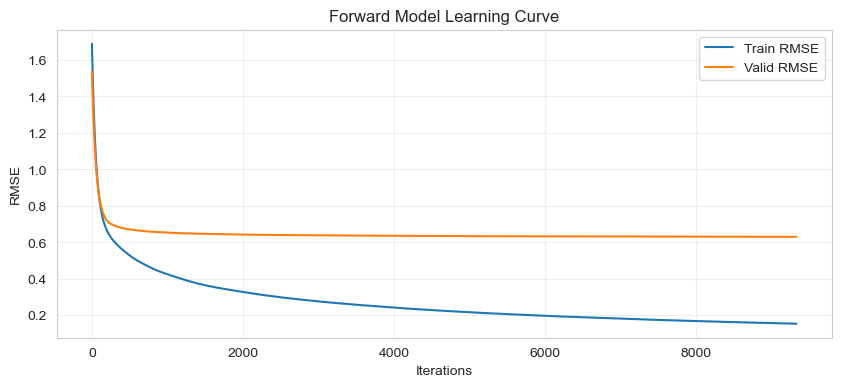

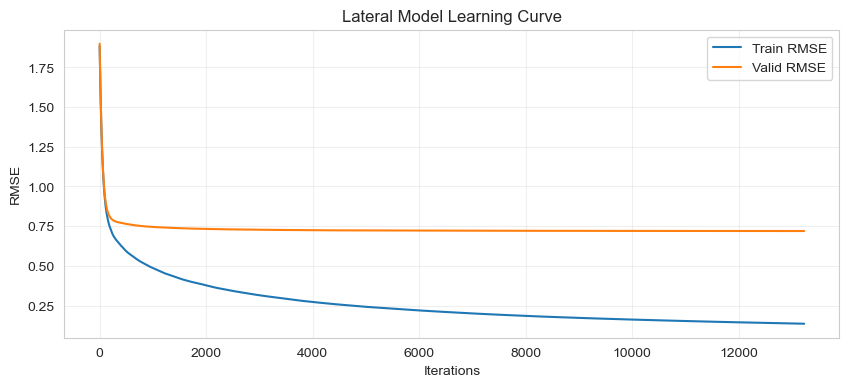

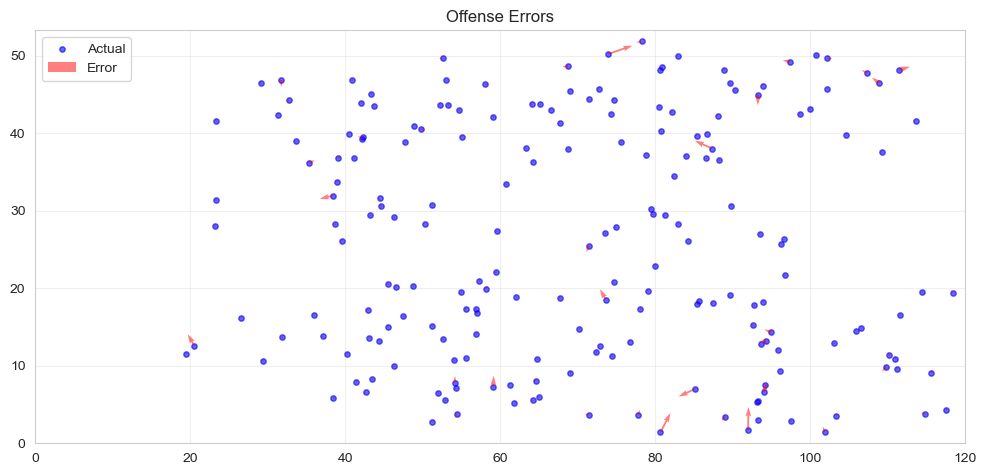

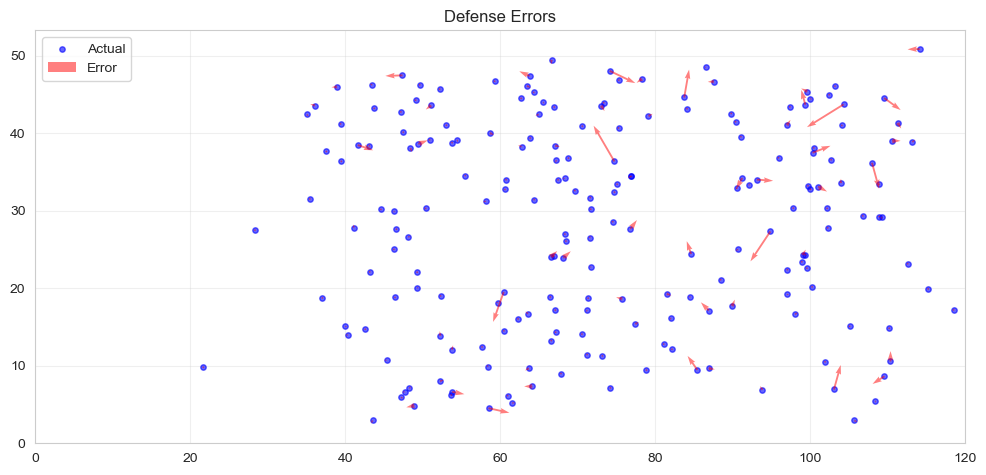

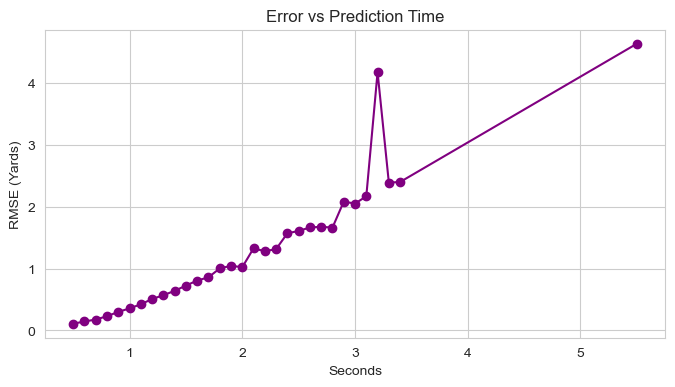

--- INVESTIGATING 3.2s SPIKE (POST-FIX) ---
Total samples at 3.2s: 288
Mean RMSE at 3.2s:     4.17 yards

--- TOP 5 WORST PREDICTIONS AT 3.2s ---
           game_id  play_id  nfl_id  is_offense play_direction  start_x      x     x_pred  start_y      y     y_pred      sq_err
524403  2023123110     3507   39908           0           left    53.56  55.03  68.483627    27.24  14.36  18.161197  195.449174
524402  2023123110     3507   39908           0           left    53.56  54.86  68.055201    27.24  14.34  18.350187  190.194939
524401  2023123110     3507   39908           0           left    53.56  54.67  67.636816    27.24  14.34  18.389591  184.537501
524400  2023123110     3507   39908           0           left    53.56  54.49  67.091655    27.24  14.35  18.365061  174.922426
524399  2023123110     3507   39908           0           left    53.56  54.30  66.481761    27.24  14.38  18.393325  164.502068


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# ==============================================================================
# UNIFIED EVALUATION BLOCK (Report + Visuals)
# ==============================================================================

print("\n Generating Full Evaluation...")

# 1. SETUP & PREDICTION
# ------------------------------------------------------------------------------
viz_df = valid_data.copy()


# Ensure Role Context
def ensure_role_context(df):
    if 'is_offense' not in df.columns:
        if 'player_role' in df.columns:
            df['is_offense'] = df['player_role'].isin(['Targeted Receiver', 'Ball Carrier']).astype(int)
        elif 'club' in df.columns and 'possession_team' in df.columns:
            df['is_offense'] = (df['club'] == df['possession_team']).astype(int)
        elif 'possessionTeam' in df.columns and 'team' in df.columns:
            df['is_offense'] = (df['team'] == df['possessionTeam']).astype(int)
        else:
            df['is_offense'] = 0
    return df


viz_df = ensure_role_context(viz_df)

# *** PREDICTION LOGIC ***
print(f"   Predicting FWD ({len(FEATS_FWD)} feats) and LAT ({len(FEATS_LAT)} feats)...")
viz_df['pred_res_fwd'] = model_fwd.predict(viz_df[FEATS_FWD])
viz_df['pred_res_lat'] = model_lat.predict(viz_df[FEATS_LAT])

theta = viz_df['start_dir_rad']
c, s = np.cos(theta), np.sin(theta)

# Rotate predictions back to Global Frame
global_res_dx = (viz_df['pred_res_fwd'] * c) - (viz_df['pred_res_lat'] * s)
global_res_dy = (viz_df['pred_res_fwd'] * s) + (viz_df['pred_res_lat'] * c)

# Add to Physics Baseline
viz_df['x_pred'] = viz_df['start_x'] + viz_df['base_dx'] + global_res_dx
viz_df['y_pred'] = viz_df['start_y'] + viz_df['base_dy'] + global_res_dy

# Calculate Squared Errors
viz_df['sq_err'] = (viz_df['x'] - viz_df['x_pred']) ** 2 + (viz_df['y'] - viz_df['y_pred']) ** 2

# 2. TEXTUAL METRICS REPORT
# ------------------------------------------------------------------------------
rmse_global = np.sqrt(viz_df['sq_err'].mean())

if viz_df['is_offense'].sum() > 0:
    rmse_offense = np.sqrt(viz_df[viz_df['is_offense'] == 1]['sq_err'].mean())
else:
    rmse_offense = 0.0

if (len(viz_df) - viz_df['is_offense'].sum()) > 0:
    rmse_defense = np.sqrt(viz_df[viz_df['is_offense'] == 0]['sq_err'].mean())
else:
    rmse_defense = 0.0

rmse_res_fwd = np.sqrt(mean_squared_error(viz_df['res_fwd'], viz_df['pred_res_fwd']))
rmse_res_lat = np.sqrt(mean_squared_error(viz_df['res_lat'], viz_df['pred_res_lat']))

# Spike Check
rmse_spike = np.sqrt(viz_df[viz_df['total_time'] > 3.0]['sq_err'].mean())

print("\n" + "=" * 40)
print("        MODEL PERFORMANCE REPORT       ")
print("=" * 40)
print(f" FIELD POSITION METRICS (Lower is Better):")
print(f"   ------------------------------------------")
print(f"    OVERALL RMSE:      {rmse_global:.4f} yards")
print(f"    SPIKE (>3s) RMSE:  {rmse_spike:.4f} yards")
print(f"   ------------------------------------------")
print(f"    Offense RMSE:      {rmse_offense:.4f} yards")
print(f"    Defense RMSE:      {rmse_defense:.4f} yards")
print(f"    Gap (Def - Off):   {rmse_defense - rmse_offense:.4f} yards")
print(f"\n PERFORMANCE (Residual RMSE):")
print(f"   ------------------------------------------")
print(f"    Forward Model:     {rmse_res_fwd:.4f}")
print(f"    Lateral Model:     {rmse_res_lat:.4f}")
print("=" * 40 + "\n")


# 3. VISUALIZATIONS
# ------------------------------------------------------------------------------

# A. Learning Curves
def plot_learning_curve(model, name):
    res = model.get_evals_result()
    key = 'validation' if 'validation' in res else 'test' if 'test' in res else None
    if not key: return

    plt.figure(figsize=(10, 4))
    if 'learn' in res: plt.plot(res['learn']['RMSE'], label='Train RMSE')
    plt.plot(res[key]['RMSE'], label='Valid RMSE')
    plt.title(f"{name} Learning Curve");
    plt.xlabel("Iterations");
    plt.ylabel("RMSE");
    plt.legend();
    plt.grid(True, alpha=0.3);
    plt.show()


plot_learning_curve(model_fwd, "Forward Model")
plot_learning_curve(model_lat, "Lateral Model")


# B. Quiver Plots (Error Vectors)
def plot_quiver(df, title, n=200):
    if len(df) > n: df = df.sample(n, random_state=42)
    plt.figure(figsize=(12, 6))

    # Plot Actual Positions
    plt.scatter(df['x'], df['y'], c='blue', alpha=0.6, s=15, label='Actual')

    # Plot Error Vectors (Red arrows showing deviation)
    plt.quiver(df['x'], df['y'],
               df['x_pred'] - df['x'],
               df['y_pred'] - df['y'],
               angles='xy', scale_units='xy', scale=1,
               color='red', alpha=0.5, width=0.002, label='Error')

    plt.title(title);
    plt.xlim(0, 120);
    plt.ylim(0, 53.3);
    plt.legend();
    plt.grid(True, alpha=0.3)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


if 'is_offense' in viz_df.columns:
    plot_quiver(viz_df[viz_df['is_offense'] == 1], "Offense Errors")
    plot_quiver(viz_df[viz_df['is_offense'] == 0], "Defense Errors")
else:
    plot_quiver(viz_df, "Global Errors")

# C. Horizon Analysis
h_stats = viz_df.groupby('num_frames_output')['sq_err'].mean().reset_index()
h_stats['rmse'] = np.sqrt(h_stats['sq_err'])
h_stats['seconds'] = h_stats['num_frames_output'] * 0.1

plt.figure(figsize=(8, 4))
plt.plot(h_stats['seconds'], h_stats['rmse'], marker='o', color='purple')
plt.title("Error vs Prediction Time");
plt.xlabel("Seconds");
plt.ylabel("RMSE (Yards)");
plt.grid(True);
plt.show()
# ==============================================================================
# FORENSIC ANALYSIS: THE 3.2 SPIKE additional check
# ==============================================================================

# 1. Filter for the specific timeframe of the spike
spike_frames = viz_df[viz_df['num_frames_output'] == 32].copy()

print(f"--- INVESTIGATING 3.2s SPIKE (POST-FIX) ---")
print(f"Total samples at 3.2s: {len(spike_frames)}")
print(f"Mean RMSE at 3.2s:     {np.sqrt(spike_frames['sq_err'].mean()):.2f} yards")

# 2. Find the Worst Offenders
worst_offenders = spike_frames.sort_values('sq_err', ascending=False).head(5)

print("\n--- TOP 5 WORST PREDICTIONS AT 3.2s ---")
cols_view = [
    'game_id', 'play_id', 'nfl_id', 'is_offense', 'play_direction',
    'start_x', 'x', 'x_pred',  # Compare Start vs Actual vs Pred
    'start_y', 'y', 'y_pred',
    'sq_err'
]

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(worst_offenders[cols_view])

# 3. DIAGNOSIS LOGIC
top_error = worst_offenders.iloc[0]
err_x = abs(top_error['x'] - top_error['x_pred'])

In [32]:
import os
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor

# 1. Load Models
MODEL_DIR = "./"
if not os.path.exists(os.path.join(MODEL_DIR, "model_fwd_ego.cbm")):
    MODEL_DIR = "/kaggle/input/catboost-game-theory/other/default/1/"

print(f"Loading optimized models from: {MODEL_DIR}")

M_FWD = CatBoostRegressor()
M_FWD.load_model(os.path.join(MODEL_DIR, "model_fwd_ego.cbm"))

M_LAT = CatBoostRegressor()
M_LAT.load_model(os.path.join(MODEL_DIR, "model_lat_ego.cbm"))

print("Models Loaded Successfully.")

# 2. Predict Function
def predict(test_df, test_input_df):
    if hasattr(test_df, 'to_pandas'): test_df = test_df.to_pandas()
    if hasattr(test_input_df, 'to_pandas'): test_input_df = test_input_df.to_pandas()

    # A. Standardize Inputs
    anchors = standardize_coordinates(test_input_df)

    # B. Generate Context (Opponents)
    anchors = anchors.sort_values(['game_id', 'play_id', 'frame_id'])
    anchors = calculate_pairwise(anchors, lookback=LOOKBACK)

    # C. History Extraction
    anchors['dir_past'] = anchors.groupby(['game_id', 'play_id', 'nfl_id'])['dir'].shift(LOOKBACK)
    anchors['dir_past'] = anchors['dir_past'].fillna(anchors['dir'])

    anchors['s_past'] = anchors.groupby(['game_id', 'play_id', 'nfl_id'])['s'].shift(LOOKBACK)
    anchors['s_past'] = anchors['s_past'].fillna(anchors['s'])

    # D. Snapshot (Last Frame)
    anchors = anchors.groupby(['game_id', 'play_id', 'nfl_id']).tail(1)

    anchors = anchors.rename(columns={
        'x': 'start_x', 'y': 'start_y', 's': 'start_s', 'a': 'start_a',
        'dir_rad': 'start_dir_rad', 'o_rad': 'start_o_rad',
        'dir': 'start_dir_deg', 'o': 'start_o_deg',
        'dir_past': 'start_dir_deg_past',
        's_past': 'start_s_past'
    })

    anchors['nfl_id'] = anchors['nfl_id'].fillna(-1).astype(int)

    # E. Merge with Submission Template
    cols_to_merge = [
        'game_id','play_id','nfl_id','start_x','start_y','start_s','start_a',
        'start_dir_rad','start_o_rad','start_dir_deg','start_o_deg',
        'start_dir_deg_past', 'start_s_past',
        'ball_land_x','ball_land_y','num_frames_output','player_weight','play_direction',
        'opp_dx_curr','opp_dy_curr','opp_dist_curr','density_curr',
        'opp_dx_past','opp_dy_past','opp_dist_past'
    ]
    cols_available = [c for c in cols_to_merge if c in anchors.columns]

    batch = test_df.merge(anchors[cols_available], on=['game_id','play_id','nfl_id'], how='left').fillna(0)
    batch['nfl_id'] = batch['nfl_id'].astype(int)

    # F. Role Context
    if 'possessionTeam' in batch.columns and 'club' in batch.columns:
        batch['is_offense'] = (batch['club'] == batch['possessionTeam']).astype(int)
    elif 'possession_team' in batch.columns and 'club' in batch.columns:
        batch['is_offense'] = (batch['club'] == batch['possession_team']).astype(int)
    elif 'possessionTeam' in batch.columns and 'team' in batch.columns:
        batch['is_offense'] = (batch['team'] == batch['possessionTeam']).astype(int)
    else:
        batch['is_offense'] = 0

    # G. Engineer Features
    batch = engineer_features(batch)

    # H. Predict
    # Using FEATS_FWD/FEATS_LAT from the training step
    pred_fwd = M_FWD.predict(batch[FEATS_FWD])
    pred_lat = M_LAT.predict(batch[FEATS_LAT])

    # I. Reconstruct Global Coordinates
    theta = batch['start_dir_rad']
    c, s = np.cos(theta), np.sin(theta)

    global_res_dx = (pred_fwd * c) - (pred_lat * s)
    global_res_dy = (pred_fwd * s) + (pred_lat * c)

    # J. Add to DAMPED Baseline
    final_x = batch['start_x'] + batch['base_dx'] + global_res_dx
    final_y = batch['start_y'] + batch['base_dy'] + global_res_dy

    # K. Boundaries & Flip Back
    final_x = np.clip(final_x, 0, 120)
    final_y = np.clip(final_y, 0, 53.3)

    if 'play_direction' in batch.columns:
        left_mask = batch['play_direction'] == 'left'
        final_x.loc[left_mask] = 120 - final_x.loc[left_mask]
        final_y.loc[left_mask] = 53.3 - final_y.loc[left_mask]

    return pd.DataFrame({"x": final_x, "y": final_y})

# 3. Call (safe for local run)
try:
    import kaggle_evaluation.nfl_inference_server
    inference_server = kaggle_evaluation.nfl_inference_server.NFLInferenceServer(predict)
    if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
        inference_server.serve()
    else:
        inference_server.run_local_gateway(('/kaggle/input/nfl-big-data-bowl-2026-prediction/',))
except ImportError:
    print("Inference server module not found (Local Mode).")

Loading optimized models from: ./
Models Loaded Successfully.
Inference server module not found (Local Mode).
